# Remove Gaps

This script removes gaps in the reads and the genome. It contains the following steps:

- Loading and cleaning read data and reference genome data
- Visualizing overlap between reads
- Collapsing the regions where there is empty data

# Load Modules

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

# Set Variables

In [4]:
# Input variables
run_number="run3"
chrom="chr17"
dis="pompe"
# Setup
chrom_dis=f"{chrom}_{dis}"
rootdir=f"/mnt/aretian/genomics/nanopore"
datadir=f"/mnt/aretian/genomics/nanopore/{run_number}"

os.environ["run_number"]=run_number
os.environ["chrom"]=chrom
os.environ["chrom_dis"]=chrom_dis
os.environ["datadir"]=datadir

# Load and Clean Reference Genome

Info: https://lh3.github.io/2017/11/13/which-human-reference-genome-to-use

S3 nanopore directory:

s3cmd get --recursive s3://aretian-genomics/nanopore/

In [5]:
# Pull reference genome from S3
# !s3cmd get s3://aretian-genomics/nanopore/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz

# !gunzip GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz

# Index reference genome
# !samtools faidx GCA_000001405.15_GRCh38_no_alt_analysis_set.fna

### Extract chromosome from reference genome

In [6]:
%%bash
# echo "Extracting $chrom from ${datadir}/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz"
# echo "Writing to ${rootdir}/reference_genome_${chrom}.fa"

# /home/fer/miniconda3/envs/genomics/bin/samtools faidx "${datadir}/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz" $chrom > "${rootdir}/reference_genome_${chrom}.fa"


In [7]:
# Read in fasta file: remove line breaks and header
def read_fasta_genome(fasta_file,chromosome_header):
    clean_data = fasta_file.read().replace("\n", "")
    clean_data = clean_data.replace(chromosome_header,"") # get rid of header

    return clean_data

with open(f'{rootdir}/reference_genome_{chrom}.fa') as f: # update path if needed
    ref_genome = read_fasta_genome(f,f'>{chrom}')

# See https://www.bioinformatics.org/sms/iupac.html for IUPAC nucleotide codes

print(f"Unique characters: {list(set(ref_genome))}") 

print(f"Selected chromosome from reference genome is {len(ref_genome)} BP long")

Unique characters: ['A', 'W', 'S', 'C', 'G', 'T', 'N', 'K', 'R', 'Y']
Selected chromosome from reference genome is 83257441 BP long


# Load and Clean Reads

Samtools view --> format of output: http://samtools.github.io/hts-specs/SAMv1.pdf

### Read SAM file

In [8]:
usecols_list = list(range(11))
# nanopore_reads = pd.read_csv(f'{datadir}/{run_number}_{chrom_dis}.sam', sep='\t',header=None,error_bad_lines=False, warn_bad_lines=False)
nanopore_reads = pd.read_csv(f'{datadir}/{run_number}_{chrom_dis}.sam',usecols=usecols_list, sep='\t',header=None)

### Clean Reads

In [14]:
nanopore_reads = nanopore_reads.iloc[:,:11]
nanopore_reads.columns = ['QNAME', 'FLAG', 'RNAME', 'POS', 'MAPQ', 'CIGAR', 'RNEXT', 'PNEXT','TLEN', 'SEQ', 'QUAL']

# Sort and get ID
nanopore_reads = nanopore_reads.sort_values(by='POS',ascending=True) # sort based on starting index of reads
nanopore_reads['ID'] = np.nan

# Get columns of interest
nanopore_reads = nanopore_reads[['ID', 'QNAME', 'FLAG', 'RNAME', 'POS', 'MAPQ', 'CIGAR', 'RNEXT', 'PNEXT','TLEN', 'SEQ', 'QUAL']]

# Drop missing values
nanopore_reads = nanopore_reads.loc[nanopore_reads['SEQ'] != '*'] # drop any rows without a proper nucleotide sequence

# Reset index and save ID
nanopore_reads = nanopore_reads.reset_index()
nanopore_reads['ID'] = nanopore_reads.index

# Calculate END_POS
nanopore_reads['SEQ_LEN'] = nanopore_reads['SEQ'].apply(lambda x: len(x))
nanopore_reads['END_POS'] = nanopore_reads['POS']+nanopore_reads['SEQ_LEN']-1

# Descriptive Statistics

### Count and plot overlap

In [8]:
def show_reads_length():
    for ID in nanopore_reads.index:
        print(f"Leftmost index --> {nanopore_reads.loc[ID,'POS']}, Read length --> {len(nanopore_reads.loc[ID,'SEQ'])}")

def create_overlap_df():
    end_index = max(nanopore_reads['POS']) + len(nanopore_reads.loc[nanopore_reads['POS'].idxmax(),'SEQ'])
    start_index = min(nanopore_reads['POS'])
    index_range = end_index-start_index

    read_overlap = np.zeros((len(nanopore_reads),index_range)) # empty matrix for reads

    for ID in nanopore_reads.index:
    #     print(f"Adding raad cover for read {ID+1}: Index-->{nanopore_reads.loc[ID,'POS']}, length-->{len(nanopore_reads.loc[ID,'SEQ'])}")
        start = nanopore_reads.loc[ID,'POS']-start_index
        end = start+len(nanopore_reads.loc[ID,'SEQ'])
        read_overlap[ID,start:end] = 1

    summary = read_overlap.sum(axis=0)
    
    overlap_df = pd.DataFrame(data=summary,index=range(start_index,end_index), columns=['overlap_count'])
    overlap_df['position'] = overlap_df.index
    overlap_df['isempty']=overlap_df['overlap_count']==0
    
    return overlap_df

def count_empty_regions():
    win_length=10000
    emptycount = 0
    emptyregioncounter = 0

    for i in overlap_df.index:

        if overlap_df.loc[i,'isempty']==False:
            emptycount = 0
            continue

        emptycount += 1

        if emptycount >= win_length:
            emptyregioncounter +=1

        if i%100000==0:
            print(f"Loop: {i}")

    print(f"There are at most {emptyregioncounter} regions with lengths larger than {win_length}")

def plot_overlap(overlap_df):
    fig, ax = plt.subplots(dpi=150)
    # plt.plot(overlap_df[:40000]['position'],overlap_df[:40000]['overlap_count'])
    # plt.plot(overlap_df[:40000]['position'],overlap_df[:40000]['overlap_count'])
    # plt.plot(overlap_df.loc[1000000:,'position'],overlap_df.loc[1000000:,'overlap_count'])
    # plt.plot(overlap_df['position'],overlap_df['overlap_count'])
    plt.plot(overlap_df['position'],overlap_df['isempty'])
    plt.xlabel('Nucleotide Position')
    plt.ylabel('# Reads Overlapping')

# count_empty_regions()
# overlap_df = create_overlap_df()
# plot_overlap(overlap_df)

### Read Length and Position

In [9]:
# Check read length statistics
print(f"Read length statistics:")
nanopore_reads['SEQ_LEN'].describe()

Read length statistics:


count      1161.000000
mean      14356.910422
std       18321.121713
min         222.000000
25%        2156.000000
50%        7406.000000
75%       18708.000000
max      130186.000000
Name: SEQ_LEN, dtype: float64

In [10]:
# Check read pos statistics
print(f"Read position statistics:")
nanopore_reads['POS'].describe()

Read position statistics:


count    1.161000e+03
mean     5.256842e+06
std      1.138441e+06
min      3.199746e+06
25%      4.278872e+06
50%      5.255851e+06
75%      6.216842e+06
max      7.218912e+06
Name: POS, dtype: float64

Trim reference genome chromosome to locus of interest 

# Collapse Gaps 

### Extract location of interest from Reference Genome

In [11]:
ref_genome = ref_genome[min(nanopore_reads['POS']):max(nanopore_reads['END_POS'])]
print(f"Selected locus for chromosome from reference genome is {len(ref_genome)} BP long")

Selected locus for chromosome from reference genome is 4080269 BP long


### Reset start and end positions based on location of interest

In [12]:
shift = min(nanopore_reads['POS'])

# archive old positions
nanopore_reads['ORIG_POS'] = nanopore_reads['POS']
nanopore_reads['ORIG_END_POS'] = nanopore_reads['END_POS']

# shift positions
nanopore_reads['POS'] = nanopore_reads['POS']-shift
nanopore_reads['END_POS'] = nanopore_reads['END_POS']-shift

nanopore_reads = nanopore_reads.reset_index() # to make the next step easier
nanopore_reads = nanopore_reads[['ID', 'QNAME', 'FLAG', 'RNAME', 'POS', 'MAPQ', 'CIGAR','RNEXT', 'PNEXT', 'TLEN', 'SEQ', 'QUAL', 'SEQ_LEN', 'END_POS','ORIG_POS', 'ORIG_END_POS']]

### Remove gaps

In [12]:
confirmed_gaps = [] # Collect gaps in list
max_end_pos = 0 # Store end position of longest read
# Initialize island counter
islandID_counter=0
nanopore_reads.loc[index:,"islandID"]=islandID_counter            

for index in nanopore_reads.index:
 
    current_read_end = nanopore_reads.loc[index,'END_POS']
    
    # Current read is redundant, skip
    if current_read_end <= max_end_pos:
        continue
        
    # This is a "standard" read (not embedded)    
    elif current_read_end > max_end_pos: 
 
        current_read_start = nanopore_reads.loc[index,'POS']
        
        # There is no gap, update max_end_pos
        if current_read_start <= max_end_pos: 
            max_end_pos = current_read_end 
            continue
            
        # There is a gap, remove it  
        elif current_read_start > max_end_pos: 
            gap_start = max_end_pos+1
            gap_end = current_read_start-1
            shift = gap_end - gap_start + 1
         
            nanopore_reads.loc[index:,'POS']     = nanopore_reads.loc[index:,'POS']    -shift
            nanopore_reads.loc[index:,'END_POS'] = nanopore_reads.loc[index:,'END_POS']-shift

            # Calculate gap based on original position
            orig_gap_end   = nanopore_reads.loc[index,'ORIG_POS'] - 1
            orig_gap_start = orig_gap_end - shift + 1
            orig_gap = (orig_gap_start,orig_gap_end)
            confirmed_gaps.append(orig_gap) # Add gap to list
     
            current_read_end = nanopore_reads.loc[index,'END_POS']
            max_end_pos = current_read_end # Current read end should always be larger than max_end_pos
            
            islandID_counter += 1
            nanopore_reads.loc[index:,"islandID"]=islandID_counter            
            
#             nanopore_reads.loc[:index,"islandID"]=islandID_counter
    

#      try:       
#         # Current read is not redundant, then update max_end_pos
#         max_end_pos = current_read_end
        
#         next_read_start = nanopore_reads.loc[index+1,'POS']

#         delta = next_read_start-current_read_end

#         if delta <= 0: # There is overlap, so no problem
#             continue 
#         elif delta > 0: # There is a gap
#             # Calculate gap based on original position
#             gap_start = nanopore_reads.loc[index  ,'ORIG_END_POS']
#             gap_end   = nanopore_reads.loc[index+1,'ORIG_POS']
#             orig_gap = (gap_start+1,gap_end-1)
#             confirmed_gaps.append(orig_gap) # Add gap to list
            
#             # Calculate gap based on adjusted positions
#             gap = (current_read_end+1,next_read_start-1)
          
#             # Shift remaining reads to the left
#             shift = gap[1]-gap[0]+1 
#             # Check shift is the same with original position data
#             shift_check = orig_gap[1]-orig_gap[0]+1
#             if shift!=shift_check:
#                 print(f"Found difference: orig_gap: {orig_gap}, gap: {gap}.")
#                 print(f"Difference: orig_gap {shift_check}, gap {shift}")
#             try:
#                 nanopore_reads.loc[(index+1):,'POS'] = nanopore_reads.loc[index+1:,'POS']-shift
#                 nanopore_reads.loc[(index+1):,'END_POS'] = nanopore_reads.loc[index+1:,'END_POS']-shift
#             except:
#                 pass

#     except:
#         pass
            
print(f"There are {len(confirmed_gaps)} gaps.")

There are 29 gaps.


### Check if gaps overlap

In [15]:
previous_gap_end = 0
for gap in confirmed_gaps:
    gap_start = gap[0]
    
    if gap_start <= previous_gap_end: # we have a problem
        print(f"Found an intersection in gap {gap}.")
    
    # Update gap_end for next iteration
    previous_gap_end = gap[1]

# Plot shift in gaps

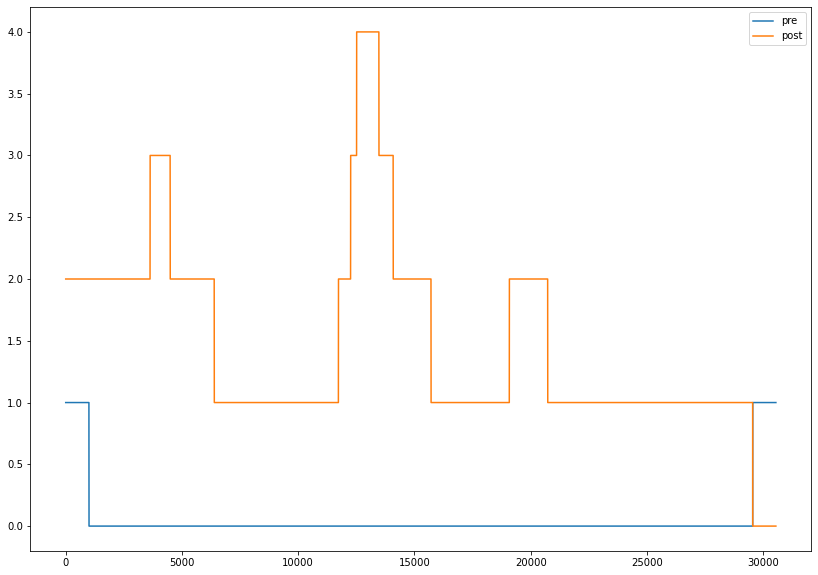

In [18]:
### shift positions
def plot_overlap_check(gap_number):
    
    # Reset ORIG_POS to zero for plotting
    shift = min(nanopore_reads['ORIG_POS'])
    nanopore_reads['ORIG_POS_plot'] = nanopore_reads['ORIG_POS']-shift
    nanopore_reads['ORIG_END_POS_plot'] = nanopore_reads['ORIG_END_POS']-shift

    # Create template
    pre_overlap  = np.zeros(len(range(min(nanopore_reads['ORIG_POS_plot']),max(nanopore_reads['ORIG_END_POS_plot']))))
    post_overlap = np.zeros(len(range(min(nanopore_reads['ORIG_POS_plot']),max(nanopore_reads['ORIG_END_POS_plot']))))

#     post_overlap = np.zeros(len(range(min(nanopore_reads['POS'])          ,max(nanopore_reads['END_POS']          ))))

    # Plot
    selected=confirmed_gaps[gap_number]
    padding=1000
 
    # Center post_overlap reads at beginning of gap
    key_read = nanopore_reads.loc[nanopore_reads['ORIG_POS']>selected[0]].iloc[0]
    
    # Calculate shift in first read
    shift2 = key_read['ORIG_POS_plot']- key_read['POS']
    
    # Shift all reads to align in plot
    nanopore_reads['POS_plot']     = nanopore_reads['ORIG_POS_plot'] + shift2
    nanopore_reads['END_POS_plot'] = nanopore_reads['ORIG_END_POS_plot'] + shift2

#     nanopore_reads.loc[nanopore_reads['ORIG_POS']-padding>selected[0],'END_POS_plot'] = nanopore_reads.loc[nanopore_reads['ORIG_POS']-padding>selected[0],'ORIG_END_POS_plot'] + shift2
    
# nanopore_reads.loc[nanopore_reads['ID']>=]
#     print(key_read)
    
#     print(shift2)
#     print(selected[1]-selected[0]+1)
    
    # Populate template
#     count = 0
    for index,read in nanopore_reads.iterrows():
    #     print(read['ORIG_POS_plot'])
    #     print(read['POS'])
        pre_overlap [read['ORIG_POS_plot']:read['ORIG_END_POS_plot']] += 1
        post_overlap[read['POS_plot'] :read['END_POS_plot'] ] += 1
#         count +=1

    # print(count)
  
    pre_overlap_plot = pre_overlap[selected[0]-padding-shift:selected[1]+padding-shift]
    post_overlap_plot = post_overlap[selected[0]-padding-shift:selected[1]+padding-shift]

    fig,ax = plt.subplots(figsize=(14,10))
    ax=plt.plot(pre_overlap_plot, label="pre")
    ax2=plt.plot(post_overlap_plot, label="post")
    plt.legend()

gap_number=0
plot_overlap_check(gap_number)

### Adjust reference_genome based on removed indices

In [19]:
# Reset confirmed_gaps to start at 0
shift = min(nanopore_reads['ORIG_POS'])
orig_confirmed_gaps = [(gap[0]-shift, gap[1]-shift) for gap in confirmed_gaps]

indices_to_remove = []
for gap in orig_confirmed_gaps:
    for i in range(gap[0],gap[1]+1):
        indices_to_remove.append(i)

print(f"Removing {len(confirmed_gaps)} gaps = {len(indices_to_remove):,} basepairs.")
print(f"Reference genome length before collapsing gaps: {len(ref_genome):,} basepairs.")
print(f"Final genome length should be: {len(ref_genome)-len(indices_to_remove):,}")

final_genome = ''
segment_start = 0

for gap in orig_confirmed_gaps:

    gap_start = gap[0]
    gap_end = gap[1]
    
    # Cut segment until next gap
    new_segment = ref_genome[segment_start:gap_start]
    
    # Append to final genome
    final_genome = final_genome + new_segment
    
    # Start of next segment
    segment_start = gap_end + 1
    
# Add last segment
new_segment = ref_genome[segment_start:]
final_genome = final_genome + new_segment

print(f"Final genome length after collapsing gaps: {len(final_genome):,} basepairs.")

Removing 29 gaps = 114,721 basepairs.
Reference genome length before collapsing gaps: 4,080,269 basepairs.
Final genome length should be: 3,965,548
Final genome length after collapsing gaps: 3,965,548 basepairs.


# Save output

In [20]:
# Save Reference Genome
initial_position = min(nanopore_reads['ORIG_POS'])
final_genome_dict = {'initial_position':initial_position, 'reference_genome': final_genome}
with open(f'{datadir}/{run_number}_{chrom_dis}_reference_genome.json', 'w') as f:
    json.dump(final_genome_dict,f)

# Save Nanopore Reads
nanopore_reads.to_csv(f'{datadir}/{run_number}_{chrom_dis}_clean.csv', index=False)

# EXTRA CODE

### Get Gaps V2

This version identifies gaps in reads by running two loops. It was discarded because the current version does the same job with just one loop.

In [14]:
# confirmed_gaps2 = []
# for index in nanopore_reads.index:
#     try:
#         current_read_end = nanopore_reads.loc[index,'END_POS']
        
#         gaps = []
#         for index2 in nanopore_reads.index:
#             try:
#                 if index == index2: # it's the same read
#                     continue

# #                 next_read_start = nanopore_reads.loc[index+1,'POS']
#                 next_read_start = nanopore_reads.loc[index2,'POS']

#                 delta = next_read_start-current_read_end


#                 if delta < 0: # There is overlap or it's a previous read
#                     continue 
#                 elif delta==0: # There is a single nucleotide overlap
#                     continue
#                 elif delta > 0: # There is a gap
#                     gaps.append((current_read_end+1,next_read_start-1)) # range between the values
#             except:
#                 pass
            
                
                
#         minimum_gap = min(gaps, key = lambda x: x[1]-x[0])
#         confirmed_gaps2.append(minimum_gap)
        
#     except:
#         pass

# print(f"There are {len(confirmed_gaps2)} gaps")
    

### Collapse gaps

This older version takes longer to delete gaps since it iterates over a list instead of using the indexes of strings.

In [207]:
# ref_genome_list = list(ref_genome)
# for index in sorted(indices_to_remove, reverse=True):
#     del ref_genome_list[index]
# ref_genome = ''.join(ref_genome_list)

# print(f"Reference genome length after collapsing gaps: {len(ref_genome):,}")